#  Example: Parallel tempering for multimodal distributions

## Adapted from the TALENT course on Learning from Data: Bayesian Methods and Machine Learning
### York, UK, June 10-28, 2019

The original notebook was by Christian Forssen.  Revisions are by Dick Furnstahl for Physics 8805.  (More documentation is needed!)


**NOTE: This version of the notebook uses the PTSampler available from emcee before version 3 (released September 2019). This sampler is now available in a different distribution, called ptemcee (see https://github.com/willvousden/ptemcee).**

## Python imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;  sns.set(context='talk')

import emcee
from emcee import PTSampler
import corner

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

### Prior

In [2]:
# Use a Gaussian prior centered at (0,0) with variance sqrt(10)
mup = np.zeros(2)
sigp=np.sqrt(10.)
sigmap = np.diag([sigp**2, sigp**2])
sigmapinv = np.linalg.inv(sigmap)
normp = 1/np.sqrt(np.linalg.det(2*np.pi*sigmap))

In [3]:
# Define the log prior
def logp(x):
    dxp = x - mup
    return -np.dot(dxp, np.dot(sigmapinv, dxp))/2.0 \
        + np.log(normp)

### Likelihood

In [4]:
def setup_modes(sig=0.2, ratio=3.):
    # Means of the two Gaussian modes
    mu1 = np.ones(2)
    mu2 = -np.ones(2)

    # Width in each dimension (zero correlation)
    _sig = sig
    sigma1 = np.diag([_sig**2, _sig**2])
    sigma2 = np.diag([_sig**2, _sig**2])
    sigma1inv = np.linalg.inv(sigma1)
    sigma2inv = np.linalg.inv(sigma2)

    # amplitudes of the two modes and the corresponding norm factor
    _amp1 = ratio / (1+ratio)
    _amp2 = 1. / (1+ratio)
    norm1 = _amp1 / np.sqrt(np.linalg.det(2*np.pi*sigma1))
    norm2 = _amp2 / np.sqrt(np.linalg.det(2*np.pi*sigma2))
    return (mu1,mu2,sigma1inv,sigma2inv,norm1,norm2)

In [5]:
params_modes = setup_modes()

# Define the log likelihood function
def logl(x,params=params_modes):
    (mu1,mu2,sigma1inv,sigma2inv,norm1,norm2)=params
    dx1 = x - mu1
    dx2 = x - mu2
    return np.logaddexp(-np.dot(dx1, np.dot(sigma1inv, dx1))/2.0 \
                        + np.log(norm1),\
                        -np.dot(dx2, np.dot(sigma2inv, dx2))/2.0 \
                        + np.log(norm2) )

### Posterior 

In [6]:
def log_posterior(x):
    return logp(x) + logl(x)

@np.vectorize
def posterior(y,x):
    xv=np.array([x,y])
    return np.exp(logl(xv)+logp(xv))

## MH Sampling and convergence

In [7]:
print('emcee sampling (version: )', emcee.__version__)

ndim = 2  # number of parameters in the model
nwarmup = 1000
nsteps = 10000

# MH-Sampler setup
stepsize = .05
cov = stepsize * np.eye(ndim)
p0 = np.random.rand(ndim)

# initialize the sampler
sampler = emcee.MHSampler(cov, ndim, log_posterior)

emcee sampling (version: ) 2.2.1


Performing 1000 warnup iterations.
MH sampler performing 10000 samples.
CPU times: user 1.65 s, sys: 6.73 ms, total: 1.65 s
Wall time: 1.84 s
done
Mean acceptance fraction: 0.516


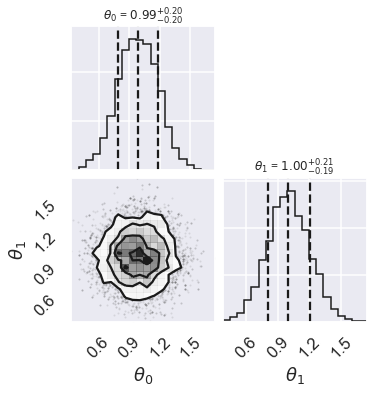

In [8]:
# Sample the posterior distribution

# Warm-up
if nwarmup > 0:
    print(f'Performing {nwarmup} warnup iterations.')
    pos, prob, state = sampler.run_mcmc(p0, nwarmup)
    sampler.reset()
else:
    pos = p0
    
# Perform iterations, starting at the final position from the warmup.
print(f'MH sampler performing {nsteps} samples.')
%time sampler.run_mcmc(pos, nsteps)
print("done")

print(f"Mean acceptance fraction: {sampler.acceptance_fraction:.3f}")

samples = sampler.flatchain
    
# make a corner plot with the posterior distribution
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels=[r"$\theta_0$", r"$\theta_1$"],
                       show_titles=True, title_kwargs={"fontsize": 12})

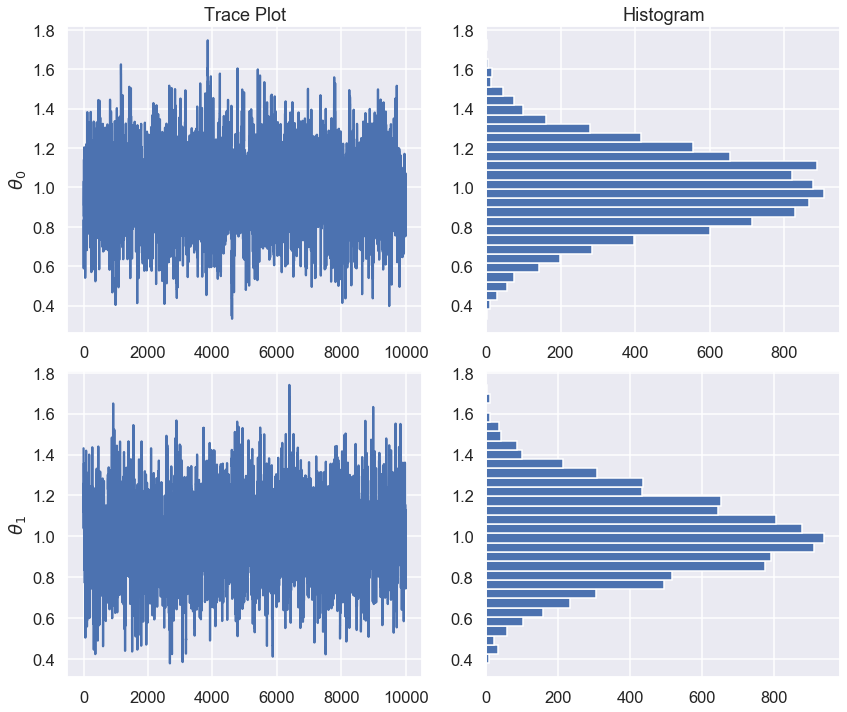

In [9]:
fix, ax = plt.subplots(2,2,figsize=(12,5*ndim))
for irow in range(ndim):
    ax[irow,0].plot(np.arange(samples.shape[0]),samples[:,irow])
    ax[irow,0].set_ylabel(r'$\theta_{0}$'.format(irow))
    ax[irow,1].hist(samples[:,irow],orientation='horizontal',bins=30)

ax[0,1].set_title('Histogram')
ax[0,0].set_title('Trace Plot')

plt.tight_layout()

In [10]:
for irow in range(ndim):
    print(f"Standard Error of the Mean for theta_{irow}: {samples[:,irow].std()/np.sqrt(samples.shape[0]):.1e}")

Standard Error of the Mean for theta_0: 2.0e-03
Standard Error of the Mean for theta_1: 2.0e-03


### Check for between chain variations

In [11]:
no_of_chains=2
chains=[]

for ichain in range(no_of_chains):
    sampler.reset()
    p0 = np.random.rand(ndim)/10 + (-1)**ichain
    # Warm-up
    if nwarmup > 0:
        print(f'Chain {ichain} performing {nwarmup} warnup iterations.')
        pos, prob, state = sampler.run_mcmc(p0, nwarmup)
        sampler.reset()
    else:
        pos = p0
    
    # Perform iterations, starting at the final position from the warmup.
    print(f'MH sampler {ichain} performing {nsteps} samples.')
    sampler.run_mcmc(pos, nsteps)
    print("done")
    print(f"Mean acceptance fraction: {sampler.acceptance_fraction:.3f}")

    chains.append(sampler.flatchain)

Chain 0 performing 1000 warnup iterations.
MH sampler 0 performing 10000 samples.
done
Mean acceptance fraction: 0.511
Chain 1 performing 1000 warnup iterations.
MH sampler 1 performing 10000 samples.
done
Mean acceptance fraction: 0.512


In [12]:
chain1 = chains[0]
chain2 = chains[1]

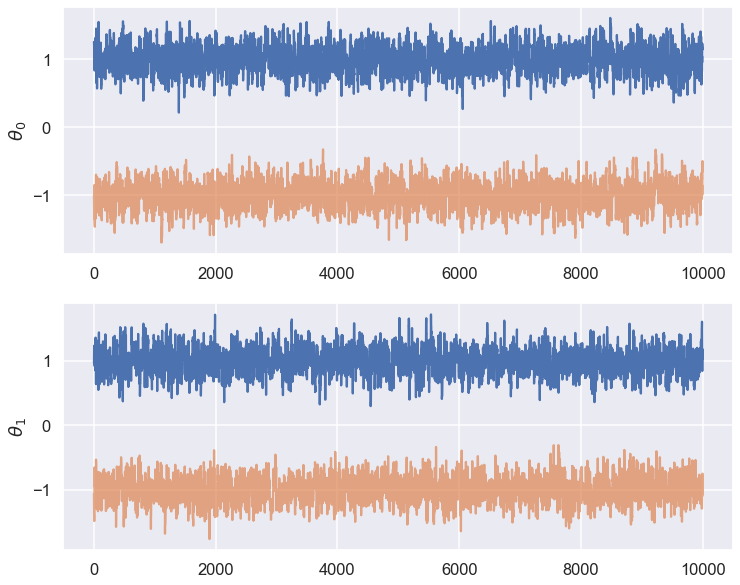

In [13]:
fix, ax = plt.subplots(2,1,figsize=(12,10))
for icol in range(ndim):
    ax[icol].plot(np.arange(chain1.shape[0]),chain1[:,icol])
    ax[icol].plot(np.arange(chain2.shape[0]),chain2[:,icol],alpha=.7)
    ax[icol].set_ylabel(r'$\theta_{0}$'.format(icol))

## This is a multimodal distribution!

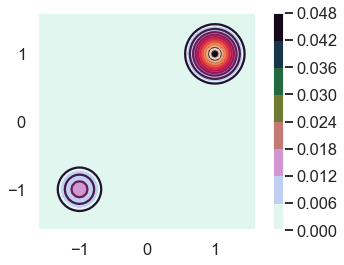

In [14]:
fig = plt.figure()
ax = fig.gca()

# Make data.
X = np.arange(-4, 4, 0.05)
Y = np.arange(-4, 4, 0.05)
X, Y = np.meshgrid(X, Y)
Z=posterior(Y,X)

ax.set_xlim([-1.6,1.6])
ax.set_ylim([-1.6,1.6])
ax.contour(X, Y, Z, 10)
CS=ax.contourf(X, Y, Z, cmap=plt.cm.cubehelix_r);
cbar = plt.colorbar(CS)
ax.set_aspect('equal', 'box')

## PT Sampler

In [15]:
# Now we can construct a sampler object that will drive the PTMCMC; 
# arbitrarily, we choose to use 21 temperatures 
# (the default is for each temperature to increase by a factor of sqrt(2), 
# so the highest temperature will be T=1024, resulting in an effective 
# \sigma_T=32\sigma=3.2, which is about the separation of our modes). 

#ntemps = 21
#temps = np.array([np.sqrt(2)**i for i in range(ntemps)])

# Modified temperature ladder to improve the integration for evidence 
# calculation: need more low temperatures, i.e. finer grid near beta=1
ntemps_lo = 8
ntemps_hi = 21
temps_lo = np.array([2**(i/8.) for i in range(ntemps_lo)])
temps_hi = np.array([np.sqrt(2)**i for i in range(ntemps_hi)])
temps = np.concatenate((temps_lo,temps_hi[temps_hi>max(temps_lo)]))
temps_string = np.array_str(temps, precision=2)
print(f'Temperature ladder: {temps_string}')
ntemps=len(temps)

# Let us use 10 walkers in the ensemble at each temperature:
nwalkers = 10
ndim = 2

nburnin = 1000
niterations=1000
nthin = 10 # only record every nthin iteration

nthreads = 8

Temperature ladder: [1.00e+00 1.09e+00 1.19e+00 1.30e+00 1.41e+00 1.54e+00 1.68e+00 1.83e+00
 2.00e+00 2.83e+00 4.00e+00 5.66e+00 8.00e+00 1.13e+01 1.60e+01 2.26e+01
 3.20e+01 4.53e+01 6.40e+01 9.05e+01 1.28e+02 1.81e+02 2.56e+02 3.62e+02
 5.12e+02 7.24e+02 1.02e+03]


In [16]:
betas=1/temps  # temps go from 1 to large, so betas go from 1 to very small

In [17]:
sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp, 
                  threads=nthreads, betas=betas)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. We could have modified the temperature ladder using the 
# betas optional argument (which should be an array of \beta=1/T values). 

# First, we run the sampler for 1000 burn-in iterations:

# p0 = np.random.uniform(low=-1.0, high=1.0, size=(ntemps, nwalkers, ndim))
p0 = np.random.normal(loc=mup, scale=sigp, size=(ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in sampler.sample(p0, iterations=nburnin):
    pass
sampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:

for p, lnprob, lnlike in sampler.sample(p, lnprob0=lnprob,
                                        lnlike0=lnlike,
                                        iterations=niterations, thin=nthin):
    pass 

Running burn-in phase
Running MCMC chains


In [18]:
#The resulting samples (nwalkers*niterations/nthin of them)
# are stored as the sampler.chain property:

assert sampler.chain.shape == (ntemps, nwalkers, niterations/nthin, ndim)
# Chain has shape (ntemps, nwalkers, nsteps, ndim)
# Zero temperature mean:
mu0 = np.mean(np.mean(sampler.chain[0,...], axis=0), axis=0)
print("The zero temperature mean is: {}".format(mu0))

(mu1,mu2,sigma1inv,sigma2inv,norm1,norm2)=params_modes
print("To be compared with likelihood distribution: ")
print("... peak 1: {}, peak 2: {}".format(mu1, mu2))

The zero temperature mean is: [0.46911647 0.46801828]
To be compared with likelihood distribution: 
... peak 1: [1. 1.], peak 2: [-1. -1.]


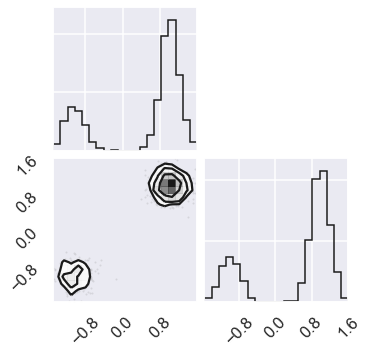

In [19]:
mcmc_data0 = sampler.chain[0,...].reshape(-1,ndim)
figure = corner.corner(mcmc_data0)

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

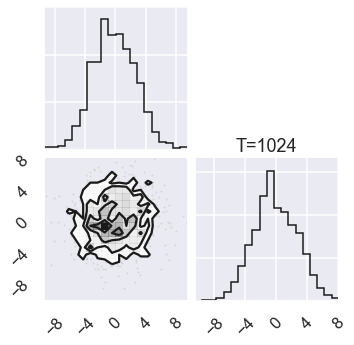

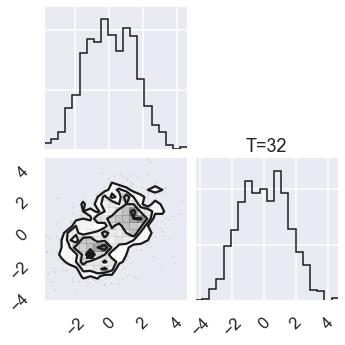

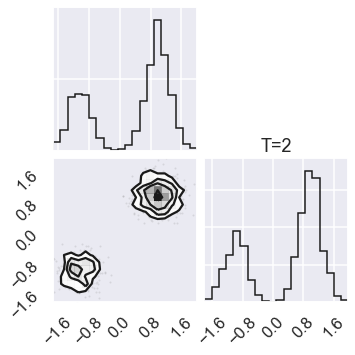

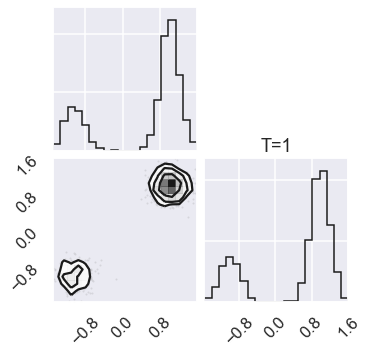

In [20]:
# Plot the posterior for four different temperatures: beta[0],beta[4],beta[10],beta[19]
ntempered=np.array([ntemps-1,ntemps-11,8,0])
for nt in ntempered:
    mcmc_data_nt = sampler.chain[nt,...].reshape(-1,ndim)
    figure = corner.corner(mcmc_data_nt)
    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))
    axes[ndim-1,ndim-1].set_title('T=%i' %temps[nt])